### Wigner function

Wigner distribution function gives the phase space distribution of a function. <br>
The definition is as follows, as per Advances in Optics and Photonics 3, 272–365 (2011) : <br><br>

$W_{f}(p,q) = \left(\dfrac{|K|}{2\pi}\right)^{N}\int f^{*}\left(q-\dfrac{q^{'}}{2}\right) f\left(q+\dfrac{q^{'}}{2}\right)exp(-iKq^{'}.p)d^{N}q^{'}$<br><br>

### Implementation
This will be implemented in two steps. First the Ambiguity function will be calclualted.<br>
Now, the WDF is just the Fourier Transform of the AF (implemented via fft)                                                                                                                       

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
from tqdm import tqdm
from numba import njit,prange

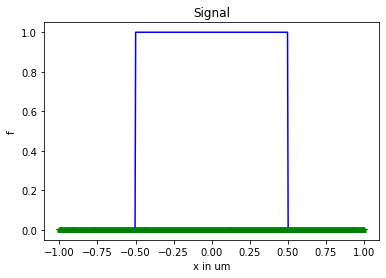

In [2]:
N = 500
f = np.zeros(N,dtype=np.complex128)
x = np.linspace(-1e-6,1e-6,N)
f[:] = 1+1j*0
f[:int(N/4)]=0+1j*0
f[int(3*N/4):]=0+1j*0
plt.plot(x*1e6,np.abs(f),'b-')
plt.plot(x*1e6,np.angle(f),'g*')
plt.ylabel('f')
plt.xlabel('x in um')
plt.title('Signal')
plt.show()

In [3]:
scale_factor = 3 #Scale domain by this much
# Assuming the domain is symmetrical, stretch on both sides
domain_real = np.linspace(scale_factor*x[0],scale_factor*x[-1],scale_factor*N) 

In [4]:
# Test function to verify positive and negative shifting of the original signal
# on a scaled domain
def f1(f,f_,y,domain):
    i = int((y-domain[0])/(domain[1]-domain[0]))
    f_[:] = 0
    N = len(f)
    f_[i-int(N/2):i+int(N/2)] = f
    return f_

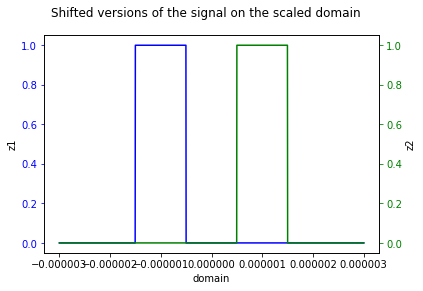

In [5]:
z1 = np.zeros(scale_factor*N,dtype=np.complex128)
z2 = np.zeros(scale_factor*N,dtype=np.complex128)
q1 = x[0]
q2 = x[-1]
z1 = f1(f,z1,q1,domain_real)
z2 = f1(f,z2,q2,domain_real)
fig,ax1 = plt.subplots(1,1)
ax1.plot(domain_real,np.abs(z1),'b')
ax1.tick_params('y', colors='b')
ax1.set_ylabel('z1')
ax2 = ax1.twinx()
ax2.plot(domain_real,np.abs(z2),'g')
ax2.tick_params('y', colors='g')
ax2.set_ylabel('z2')
ax1.set_xlabel('domain')
fig.suptitle('Shifted versions of the signal on the scaled domain')
plt.show()

In [6]:
# Computer the ambiguity function row by row.
def fill_AF(af,sig,domain,scale_factor,N):
    q1_vals = np.linspace(domain[0],domain[-1],scale_factor*N)
    for i in prange(scale_factor*N):
        q1 = q1_vals[i]
        z1 = np.zeros(scale_factor*N,dtype=np.complex128)
        z2 = np.zeros(scale_factor*N,dtype=np.complex128)
        i = int((q1/2-domain[0])/(domain[1]-domain[0]))
        z1[:] = 0
        z1[i-int(N/2):i+int(N/2)] = sig
    
        i = int((-q1/2-domain[0])/(domain[1]-domain[0]))
        z2[:] = 0
        z2[i-int(N/2):i+int(N/2)] = sig
        
        af[:,i] = z1*z2

In [7]:
AF = np.zeros((scale_factor*N,scale_factor*N),dtype=np.complex128)
fill_AF(AF,f,domain_real,scale_factor,N)
WDF = np.fft.fftshift(np.fft.fft(AF),axes=1)

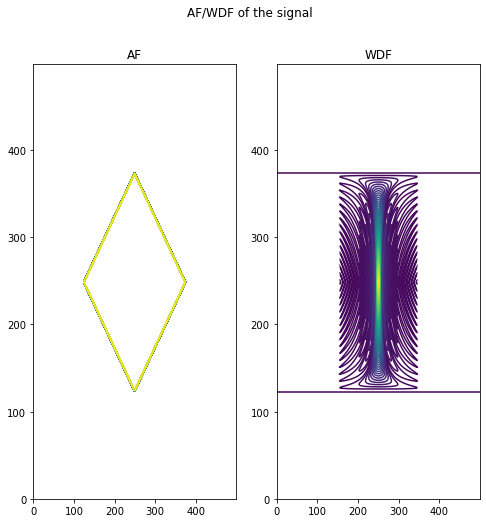

In [8]:
plt.rcParams["figure.figsize"] = (8,8)
N1 = int(scale_factor*N/2)
n1 = 250
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.contour(np.abs(AF)[N1-n1:N1+n1,N1-n1:N1+n1],50)
ax1.set_title('AF')
ax2.contour(np.abs(WDF)[N1-n1:N1+n1,N1-n1:N1+n1],50)
ax2.set_title('WDF')
fig.suptitle('AF/WDF of the signal')
plt.show()

In [9]:
energy = 1000
wavel = (1240/energy)*10**(-9)
pi = np.pi
L_in  = x[-1] - x[0]

In [10]:
from xwp.spectral_1d import propTF

/home/sajid/miniconda3/envs/ipy3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [11]:
z = 4e-6
sampling = L_in/N1
critical = (wavel*z/L_in)
if sampling>critical:
    print('Use TF')
else :
    print('Use IR/1FT')
print('Fresnel Number :', (L_in**2)/(wavel*z))

Use TF
Fresnel Number : 806.4516129032257


In [12]:
out,L_out = propTF(f,L_in/N1,L_in,wavel,z)

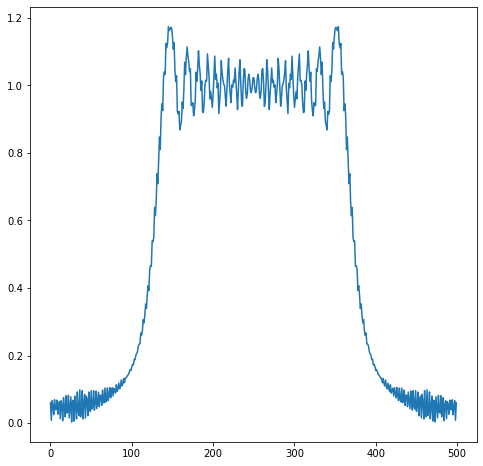

In [13]:
plt.plot(np.abs(out))
plt.show()

In [14]:
AF = np.zeros((scale_factor*N,scale_factor*N),dtype=np.complex128)
domain_real = np.linspace(-L_out/2*scale_factor,L_out/2*scale_factor,scale_factor*N,)
fill_AF(AF,out,domain_real,scale_factor,N)
WDF = np.fft.fftshift(np.fft.fft(AF),axes=1)

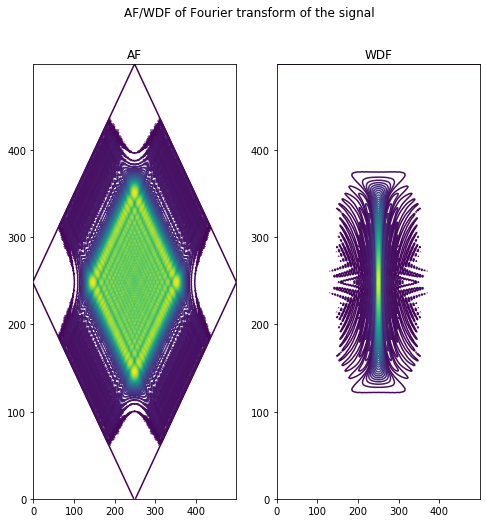

In [15]:
N1 = int(scale_factor*N/2)
n1 = 250
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.contour(np.abs(AF)[N1-n1:N1+n1,N1-n1:N1+n1],50)
ax1.set_title('AF')
ax2.contour(np.abs(WDF)[N1-n1:N1+n1,N1-n1:N1+n1],50)
ax2.set_title('WDF')
fig.suptitle('AF/WDF of Fourier transform of the signal')
plt.show()